3462


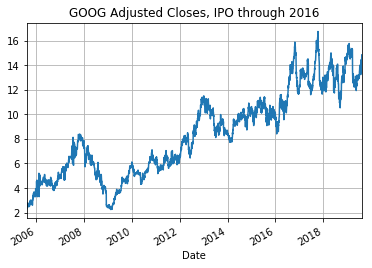

In [20]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data
#pip install pandas-datareader

stock = 'LAME3.SA'
source = 'yahoo'

# Set date range (Google went public August 19, 2004)
start = datetime.datetime(2005, 8, 19)
end = datetime.datetime(2019, 8, 8)

# Collect Google stock data
goog_df = data.DataReader(stock, source, start, end)

dataset = goog_df['Adj Close']
print(len(dataset))
goog_df['Adj Close'].plot(kind='line', grid=True, title='GOOG Adjusted Closes, IPO through 2016')


In [21]:
goog_df['Adj Close'][-1]

14.829999923706055

In [22]:
import tensorflow as tf
import pandas as pd  
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow_probability as tfp


dataset = np.array(dataset.astype('float32')).reshape(-1,1)

def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

#dataset=norm(dataset)

look_back=4
np.random.seed(7)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.99)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

def create_dataset(dataset, look_back=look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX

trainY = trainY.reshape(len(trainY), 1)
testY = testY.reshape(len(testY), 1)
trainY

X0=trainX
Y0=trainY



3427 35


In [23]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/home/rubensvectomobile_gmail_com/.local/lib/python3.5/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [24]:
tfd = tfp.distributions

class TemporalConvNet(tf.layers.Layer):
    def __init__(self, num_channels, kernel_size=2, dropout=0.2,
                 trainable=False, name=None, dtype=None, 
                 activity_regularizer=None, **kwargs):
        super(TemporalConvNet, self).__init__(
            trainable=trainable, dtype=dtype,
            activity_regularizer=activity_regularizer,
            name=name, **kwargs
        )
        self.layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            out_channels = num_channels[i]
            self.layers.append(
                TemporalBlock(out_channels, kernel_size, strides=1, dilation_rate=dilation_size,
                              dropout=dropout, name="tblock_{}".format(i))
            )
    
    def call(self, inputs, training=False):
        outputs = inputs
        for layer in self.layers:
            outputs = layer(outputs, training=training)
        return outputs

learning_rate = 0.001
display_step = 10
num_input = 1
num_hidden = 35
num_classes = 1

dropout = 0
kernel_size = 8
levels = 6

class CausalConv1D(tf.layers.Conv1D):
    def __init__(self, filters,
               kernel_size,
               strides=1,
               dilation_rate=1,
               activation=None,
               use_bias=True,
               kernel_initializer=None,
               bias_initializer=tf.zeros_initializer(),
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               trainable=False,
               name=None,
               **kwargs):
        super(CausalConv1D, self).__init__(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding='valid',
            data_format='channels_last',
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            trainable=trainable,
            name=name, **kwargs
        )
       
    def call(self, inputs):
        padding = (self.kernel_size[0] - 1) * self.dilation_rate[0]
        inputs = tf.pad(inputs, tf.constant([(0, 0,), (1, 0), (0, 0)]) * padding)
        return super(CausalConv1D, self).call(inputs)



class TemporalBlock(tf.layers.Layer):
    def __init__(self, n_outputs, kernel_size, strides, dilation_rate, dropout=0.2, 
                 trainable=False, name=None, dtype=None, 
                 activity_regularizer=None, **kwargs):
        super(TemporalBlock, self).__init__(
            trainable=trainable, dtype=dtype,
            activity_regularizer=activity_regularizer,
            name=name, **kwargs
        )        
        self.dropout = dropout
        self.n_outputs = n_outputs
        self.conv1 = CausalConv1D(
            n_outputs, kernel_size, strides=strides, 
            dilation_rate=dilation_rate, activation=tf.nn.relu, 
            name="conv1")
        self.conv2 = CausalConv1D(
            n_outputs, kernel_size, strides=strides, 
            dilation_rate=dilation_rate, activation=tf.nn.relu, 
            name="conv2")
        self.down_sample = None

    
    def build(self, input_shape):
        channel_dim = 2
        self.dropout1 = tf.layers.Dropout(self.dropout, [tf.constant(1), tf.constant(1), tf.constant(self.n_outputs)])
        self.dropout2 = tf.layers.Dropout(self.dropout, [tf.constant(1), tf.constant(1), tf.constant(self.n_outputs)])
        if input_shape[channel_dim] != self.n_outputs:
            self.down_sample = tf.layers.Dense(self.n_outputs, activation=None)
    
    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = tf.contrib.layers.layer_norm(x)
        x = self.dropout1(x, training=training)
        x = self.conv2(x)
        x = tf.contrib.layers.layer_norm(x)
        x = self.dropout2(x, training=training)
        #x = tfp.layers.DistributionLambda(make_distribution_fn=lambda t: tfd.Normal(loc=t, scale=1))(x)
        #x = tf.contrib.layers.layer_norm(x)
        #x = tf.layers.dense(inputs=x,units=3)
        if self.down_sample is not None:
          inputs = self.down_sample(inputs)
        return tf.nn.relu(x)



tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    tf.set_random_seed(2)
    
    X = tf.placeholder("float", [None, look_back,1])
    Y = tf.placeholder("float", [None, num_classes])
    is_training = tf.placeholder("bool")
    
    logits = tf.layers.dense(
        TemporalConvNet([num_hidden] * levels, kernel_size, dropout)(
            X, training=is_training),
        num_classes, activation=None, 
        kernel_initializer=tf.glorot_uniform_initializer()
    )
    print(logits)

    mm,_=tf.nn.moments(tf.reshape(tf.nn.relu(logits),[-1,look_back]),axes=[1])
    prediction=tf.nn.relu(logits)
    
    prediction2 = tf.reshape(tf.cast(mm,tf.float32),[-1,1])
    
    loss_op = tf.reduce_mean(tf.losses.mean_squared_error(
        labels=Y,predictions=prediction2))
    
    accuracy=1-tf.sqrt(loss_op)

    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    train_op = optimizer.minimize(loss_op)


    saver = tf.train.Saver()
    print("All parameters:", np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.global_variables()]))
    print("Trainable parameters:", np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()]))

def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    return np.asarray(data_shuffle).astype(np.float32), np.asarray(labels_shuffle).astype(np.float32)

log_dir = "/home/rubensvectomobile/BOVESPA/"
tb_writer = tf.summary.FileWriter(log_dir, graph)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.7
best_val_acc = 0.93

training_epochs = 8000
batch_size = int(trainX.shape[0]/4)


X0=X0.reshape(-1,look_back,1)
testX=testX.reshape(-1,look_back,1)


Tensor("dense/BiasAdd:0", shape=(?, 4, 1), dtype=float32)
All parameters: 111200.0
Trainable parameters: 946


In [25]:

with tf.Session(graph=graph, config=config) as sess:
    #init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    #sess.run(init)
    ckpt = "/home/rubensvectomobile/BOVESPA/real/model.ckpt"
    saver.restore(sess, ckpt)

    for step in range(1, training_epochs+1):
        Xt, Yt = next_batch(batch_size, X0, Y0)
        batch_x, batch_y = Xt,Yt
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, is_training: True})
        if step % display_step == 0 or step == 1:
            loss, acc = sess.run([loss_op, accuracy], feed_dict={
                X: batch_x, Y: batch_y, is_training: False})
            test_data = testX
            test_label = testY
            val_acc = sess.run(accuracy, feed_dict={X: test_data, Y: test_label, is_training: False})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.4f}".format(acc) + ", Test Accuracy= " + \
                  "{:.4f}".format(val_acc))
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                save_path = saver.save(sess, "/home/rubensvectomobile/BOVESPA/real/model.ckpt")
                print("Model saved in path: %s" % save_path)
    pred00 = sess.run([prediction], feed_dict={X: test_data, is_training: False})
    pred01 = sess.run([prediction2], feed_dict={X: test_data, is_training: False})


Step 1, Minibatch Loss= 0.0004, Training Accuracy= 0.9808, Test Accuracy= 0.9709
Model saved in path: /home/rubensvectomobile/BOVESPA/real/model.ckpt
Step 10, Minibatch Loss= 0.0004, Training Accuracy= 0.9813, Test Accuracy= 0.9715
Model saved in path: /home/rubensvectomobile/BOVESPA/real/model.ckpt
Step 20, Minibatch Loss= 0.0003, Training Accuracy= 0.9822, Test Accuracy= 0.9722
Model saved in path: /home/rubensvectomobile/BOVESPA/real/model.ckpt
Step 30, Minibatch Loss= 0.0003, Training Accuracy= 0.9829, Test Accuracy= 0.9726
Model saved in path: /home/rubensvectomobile/BOVESPA/real/model.ckpt
Step 40, Minibatch Loss= 0.0003, Training Accuracy= 0.9822, Test Accuracy= 0.9729
Model saved in path: /home/rubensvectomobile/BOVESPA/real/model.ckpt
Step 50, Minibatch Loss= 0.0003, Training Accuracy= 0.9832, Test Accuracy= 0.9734
Model saved in path: /home/rubensvectomobile/BOVESPA/real/model.ckpt
Step 60, Minibatch Loss= 0.0004, Training Accuracy= 0.9804, Test Accuracy= 0.9739
Model saved i

Step 890, Minibatch Loss= 0.0003, Training Accuracy= 0.9825, Test Accuracy= 0.9752
Step 900, Minibatch Loss= 0.0003, Training Accuracy= 0.9829, Test Accuracy= 0.9753
Step 910, Minibatch Loss= 0.0003, Training Accuracy= 0.9829, Test Accuracy= 0.9756
Step 920, Minibatch Loss= 0.0003, Training Accuracy= 0.9839, Test Accuracy= 0.9752
Step 930, Minibatch Loss= 0.0003, Training Accuracy= 0.9831, Test Accuracy= 0.9743
Step 940, Minibatch Loss= 0.0003, Training Accuracy= 0.9823, Test Accuracy= 0.9756
Step 950, Minibatch Loss= 0.0003, Training Accuracy= 0.9832, Test Accuracy= 0.9742
Step 960, Minibatch Loss= 0.0003, Training Accuracy= 0.9831, Test Accuracy= 0.9750
Step 970, Minibatch Loss= 0.0003, Training Accuracy= 0.9830, Test Accuracy= 0.9745
Step 980, Minibatch Loss= 0.0003, Training Accuracy= 0.9827, Test Accuracy= 0.9749
Step 990, Minibatch Loss= 0.0003, Training Accuracy= 0.9824, Test Accuracy= 0.9751
Step 1000, Minibatch Loss= 0.0003, Training Accuracy= 0.9826, Test Accuracy= 0.9758
Mod

Step 1740, Minibatch Loss= 0.0003, Training Accuracy= 0.9842, Test Accuracy= 0.9783
Step 1750, Minibatch Loss= 0.0002, Training Accuracy= 0.9849, Test Accuracy= 0.9784
Step 1760, Minibatch Loss= 0.0003, Training Accuracy= 0.9838, Test Accuracy= 0.9792
Step 1770, Minibatch Loss= 0.0003, Training Accuracy= 0.9839, Test Accuracy= 0.9783
Step 1780, Minibatch Loss= 0.0002, Training Accuracy= 0.9851, Test Accuracy= 0.9789
Step 1790, Minibatch Loss= 0.0003, Training Accuracy= 0.9840, Test Accuracy= 0.9789
Step 1800, Minibatch Loss= 0.0003, Training Accuracy= 0.9835, Test Accuracy= 0.9786
Step 1810, Minibatch Loss= 0.0002, Training Accuracy= 0.9845, Test Accuracy= 0.9786
Step 1820, Minibatch Loss= 0.0003, Training Accuracy= 0.9831, Test Accuracy= 0.9792
Model saved in path: /home/rubensvectomobile/BOVESPA/real/model.ckpt
Step 1830, Minibatch Loss= 0.0002, Training Accuracy= 0.9844, Test Accuracy= 0.9785
Step 1840, Minibatch Loss= 0.0003, Training Accuracy= 0.9837, Test Accuracy= 0.9787
Step 18

Model saved in path: /home/rubensvectomobile/BOVESPA/real/model.ckpt
Step 2660, Minibatch Loss= 0.0003, Training Accuracy= 0.9837, Test Accuracy= 0.9793
Step 2670, Minibatch Loss= 0.0002, Training Accuracy= 0.9857, Test Accuracy= 0.9789
Step 2680, Minibatch Loss= 0.0002, Training Accuracy= 0.9845, Test Accuracy= 0.9792
Step 2690, Minibatch Loss= 0.0002, Training Accuracy= 0.9851, Test Accuracy= 0.9789
Step 2700, Minibatch Loss= 0.0002, Training Accuracy= 0.9851, Test Accuracy= 0.9788
Step 2710, Minibatch Loss= 0.0003, Training Accuracy= 0.9840, Test Accuracy= 0.9789
Step 2720, Minibatch Loss= 0.0002, Training Accuracy= 0.9844, Test Accuracy= 0.9794
Step 2730, Minibatch Loss= 0.0002, Training Accuracy= 0.9848, Test Accuracy= 0.9793
Step 2740, Minibatch Loss= 0.0002, Training Accuracy= 0.9843, Test Accuracy= 0.9778
Step 2750, Minibatch Loss= 0.0002, Training Accuracy= 0.9850, Test Accuracy= 0.9794
Step 2760, Minibatch Loss= 0.0002, Training Accuracy= 0.9848, Test Accuracy= 0.9793
Step 27

Step 3630, Minibatch Loss= 0.0002, Training Accuracy= 0.9846, Test Accuracy= 0.9791
Step 3640, Minibatch Loss= 0.0002, Training Accuracy= 0.9847, Test Accuracy= 0.9796
Step 3650, Minibatch Loss= 0.0002, Training Accuracy= 0.9860, Test Accuracy= 0.9795
Step 3660, Minibatch Loss= 0.0002, Training Accuracy= 0.9846, Test Accuracy= 0.9790
Step 3670, Minibatch Loss= 0.0002, Training Accuracy= 0.9861, Test Accuracy= 0.9795
Step 3680, Minibatch Loss= 0.0002, Training Accuracy= 0.9849, Test Accuracy= 0.9797
Step 3690, Minibatch Loss= 0.0002, Training Accuracy= 0.9847, Test Accuracy= 0.9786
Step 3700, Minibatch Loss= 0.0002, Training Accuracy= 0.9857, Test Accuracy= 0.9798
Step 3710, Minibatch Loss= 0.0002, Training Accuracy= 0.9851, Test Accuracy= 0.9786
Step 3720, Minibatch Loss= 0.0002, Training Accuracy= 0.9852, Test Accuracy= 0.9792
Step 3730, Minibatch Loss= 0.0002, Training Accuracy= 0.9866, Test Accuracy= 0.9798
Model saved in path: /home/rubensvectomobile/BOVESPA/real/model.ckpt
Step 37

Step 4560, Minibatch Loss= 0.0002, Training Accuracy= 0.9864, Test Accuracy= 0.9796
Step 4570, Minibatch Loss= 0.0002, Training Accuracy= 0.9853, Test Accuracy= 0.9797
Step 4580, Minibatch Loss= 0.0002, Training Accuracy= 0.9846, Test Accuracy= 0.9797
Step 4590, Minibatch Loss= 0.0002, Training Accuracy= 0.9862, Test Accuracy= 0.9796
Step 4600, Minibatch Loss= 0.0002, Training Accuracy= 0.9852, Test Accuracy= 0.9801
Model saved in path: /home/rubensvectomobile/BOVESPA/real/model.ckpt
Step 4610, Minibatch Loss= 0.0002, Training Accuracy= 0.9857, Test Accuracy= 0.9794
Step 4620, Minibatch Loss= 0.0002, Training Accuracy= 0.9848, Test Accuracy= 0.9785
Step 4630, Minibatch Loss= 0.0002, Training Accuracy= 0.9852, Test Accuracy= 0.9795
Step 4640, Minibatch Loss= 0.0002, Training Accuracy= 0.9847, Test Accuracy= 0.9795
Step 4650, Minibatch Loss= 0.0002, Training Accuracy= 0.9857, Test Accuracy= 0.9796
Step 4660, Minibatch Loss= 0.0002, Training Accuracy= 0.9845, Test Accuracy= 0.9793
Step 46

Step 5510, Minibatch Loss= 0.0002, Training Accuracy= 0.9852, Test Accuracy= 0.9794
Step 5520, Minibatch Loss= 0.0002, Training Accuracy= 0.9864, Test Accuracy= 0.9800
Step 5530, Minibatch Loss= 0.0002, Training Accuracy= 0.9852, Test Accuracy= 0.9802
Step 5540, Minibatch Loss= 0.0002, Training Accuracy= 0.9847, Test Accuracy= 0.9794
Step 5550, Minibatch Loss= 0.0003, Training Accuracy= 0.9841, Test Accuracy= 0.9799
Step 5560, Minibatch Loss= 0.0002, Training Accuracy= 0.9848, Test Accuracy= 0.9803
Step 5570, Minibatch Loss= 0.0003, Training Accuracy= 0.9841, Test Accuracy= 0.9792
Step 5580, Minibatch Loss= 0.0002, Training Accuracy= 0.9856, Test Accuracy= 0.9796
Step 5590, Minibatch Loss= 0.0002, Training Accuracy= 0.9854, Test Accuracy= 0.9793
Step 5600, Minibatch Loss= 0.0002, Training Accuracy= 0.9857, Test Accuracy= 0.9796
Step 5610, Minibatch Loss= 0.0002, Training Accuracy= 0.9856, Test Accuracy= 0.9798
Step 5620, Minibatch Loss= 0.0002, Training Accuracy= 0.9857, Test Accuracy=

Step 6460, Minibatch Loss= 0.0002, Training Accuracy= 0.9846, Test Accuracy= 0.9799
Step 6470, Minibatch Loss= 0.0002, Training Accuracy= 0.9860, Test Accuracy= 0.9800
Step 6480, Minibatch Loss= 0.0002, Training Accuracy= 0.9850, Test Accuracy= 0.9801
Step 6490, Minibatch Loss= 0.0002, Training Accuracy= 0.9861, Test Accuracy= 0.9799
Step 6500, Minibatch Loss= 0.0002, Training Accuracy= 0.9854, Test Accuracy= 0.9806
Step 6510, Minibatch Loss= 0.0002, Training Accuracy= 0.9864, Test Accuracy= 0.9802
Step 6520, Minibatch Loss= 0.0002, Training Accuracy= 0.9858, Test Accuracy= 0.9792
Step 6530, Minibatch Loss= 0.0002, Training Accuracy= 0.9851, Test Accuracy= 0.9807
Step 6540, Minibatch Loss= 0.0002, Training Accuracy= 0.9862, Test Accuracy= 0.9805
Step 6550, Minibatch Loss= 0.0002, Training Accuracy= 0.9853, Test Accuracy= 0.9796
Step 6560, Minibatch Loss= 0.0002, Training Accuracy= 0.9854, Test Accuracy= 0.9805
Step 6570, Minibatch Loss= 0.0002, Training Accuracy= 0.9855, Test Accuracy=

Step 7400, Minibatch Loss= 0.0002, Training Accuracy= 0.9851, Test Accuracy= 0.9803
Step 7410, Minibatch Loss= 0.0002, Training Accuracy= 0.9861, Test Accuracy= 0.9805
Step 7420, Minibatch Loss= 0.0002, Training Accuracy= 0.9851, Test Accuracy= 0.9807
Step 7430, Minibatch Loss= 0.0002, Training Accuracy= 0.9854, Test Accuracy= 0.9803
Step 7440, Minibatch Loss= 0.0002, Training Accuracy= 0.9851, Test Accuracy= 0.9802
Step 7450, Minibatch Loss= 0.0002, Training Accuracy= 0.9856, Test Accuracy= 0.9805
Step 7460, Minibatch Loss= 0.0002, Training Accuracy= 0.9865, Test Accuracy= 0.9794
Step 7470, Minibatch Loss= 0.0002, Training Accuracy= 0.9857, Test Accuracy= 0.9807
Step 7480, Minibatch Loss= 0.0002, Training Accuracy= 0.9864, Test Accuracy= 0.9799
Step 7490, Minibatch Loss= 0.0002, Training Accuracy= 0.9855, Test Accuracy= 0.9800
Step 7500, Minibatch Loss= 0.0002, Training Accuracy= 0.9859, Test Accuracy= 0.9808
Step 7510, Minibatch Loss= 0.0002, Training Accuracy= 0.9856, Test Accuracy=

In [31]:
with tf.Session(graph=graph, config=config) as session:
    ckpt = "/home/rubensvectomobile/BOVESPA/real/model.ckpt"
    saver.restore(session, ckpt)
    pred00 = session.run([prediction], feed_dict={X: test_data, is_training: False})
    pred01 = session.run([prediction2], feed_dict={X: test_data, is_training: False})
    pred02 = session.run([prediction2], feed_dict={X: trainX.reshape(-1,look_back,1), is_training: False})




W0809 19:30:58.291533 140622298318592 deprecation.py:323] From /home/rubensvectomobile_gmail_com/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


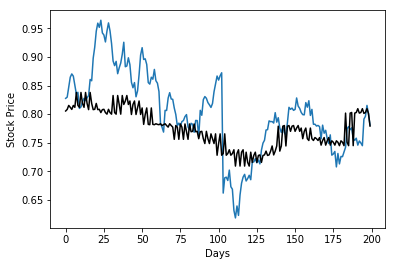

In [32]:
import matplotlib.pyplot as plt
plt.plot(np.array(pred02).reshape(-1,1)[-200:])
plt.plot(np.array(trainX).reshape(-1,)[-200:],c='black')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()

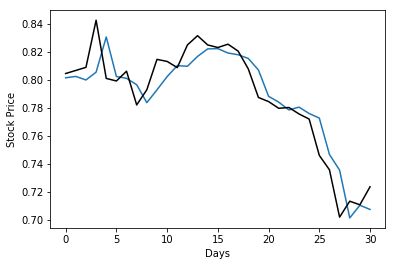

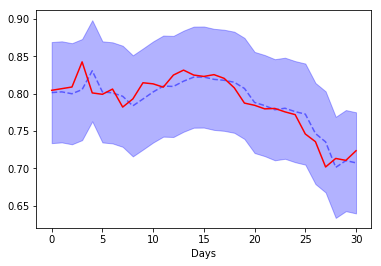

In [33]:
import matplotlib.pyplot as plt
plt.plot(np.array(pred01).reshape(-1,1))
plt.plot(np.array(testY).reshape(-1,),c='black')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()

x=list(range(0,len(pred00[0])))
y1=np.array(pred01).reshape(1,-1)[0]+2*np.std(np.array(pred01).reshape(1,-1))
y2=np.array(pred01).reshape(1,-1)[0]-2*np.std(np.array(pred01).reshape(1,-1))
fig, ax1 = plt.subplots(1, 1, sharex=True)
ax1.plot(np.array(pred01).reshape(1,-1)[0],'--',color='blue',alpha=0.5)
ax1.fill_between(x, y1, y2,color='blue',alpha=0.3)
ax1.plot(x,np.array(testY).reshape(-1,),c='red')
plt.xlabel('Days')
plt.show()

In [34]:
from sklearn.metrics import r2_score
print('R2',r2_score(testY.reshape(1,-1)[0],np.array(pred01).reshape(1,-1)[0]))

R2 0.8461312586213721


In [36]:
limit=8

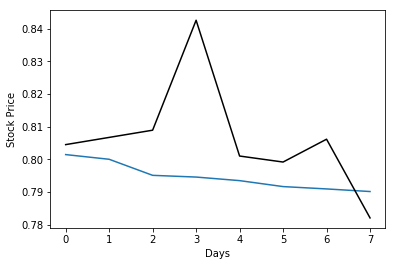

Variação Real -2.79%
Variação Prevista ['-1.41%']
Erro ['1.38%']


In [37]:
x_test=testX[0].reshape(-1,look_back,1)
prev=[]
with tf.Session(graph=graph, config=config) as session:
    ckpt = "/home/rubensvectomobile/BOVESPA/real/model.ckpt"
    saver.restore(session, ckpt)
    for i in range(0,21):
        pred02 = session.run([prediction2], feed_dict={X: x_test, is_training: False})[0][0]
        prev.append(pred02)
        #print(pred02)
        x_test=np.concatenate([x_test[0][1:look_back],[pred02]],axis=0).reshape(-1,look_back,1)
        #print(x_test)
        
plt.plot(np.array(prev)[0:limit].reshape(-1,1))
plt.plot(np.array(testY)[0:limit].reshape(-1,),c='black')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()
real=(np.array(testY)[0:limit].reshape(-1,)[-1]/np.array(testY)[0:limit].reshape(-1,)[0]-1)*100
prevista=(np.array(prev)[0:limit].reshape(-1,1)[-1]/np.array(prev)[0:limit].reshape(-1,1)[0]-1)*100
print('Variação Real',"%.2f" % real + '%')
print('Variação Prevista',["%.2f" % prevista+'%'])
print('Erro',["%.2f" % float((prevista-real))+'%'])

In [38]:
x_test=testX[-1].reshape(-1,look_back,1)
prev=[]
with tf.Session(graph=graph, config=config) as session:
    ckpt = "/home/rubensvectomobile/BOVESPA/real/model.ckpt"
    saver.restore(session, ckpt)
    for i in range(0,21):
        pred02 = session.run([prediction2], feed_dict={X: x_test, is_training: False})[0][0]
        prev.append(pred02)
        #print(pred02)
        x_test=np.concatenate([x_test[0][1:look_back],[pred02]],axis=0).reshape(-1,look_back,1)
        #print(x_test)
        


In [39]:
limit=8

In [40]:
np.array(testY)[0:limit].reshape(-1,)[-1]

0.7820822

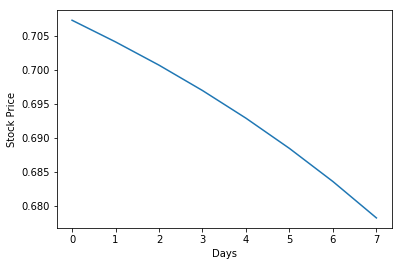

Variação Prevista ['-4.12%']


In [41]:
plt.plot(np.array(prev)[0:limit].reshape(-1,1))
#plt.plot(np.array(testY)[0:limit].reshape(-1,),c='black')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()
#real=(np.array(testY)[0:limit].reshape(-1,)[-1]/np.array(testY)[0:limit].reshape(-1,)[0]-1)*100
prevista=(np.array(prev)[0:limit].reshape(-1,1)[-1]/np.array(prev)[0:limit].reshape(-1,1)[0]-1)*100
#print('Variação Real',"%.2f" % real + '%')
print('Variação Prevista',["%.2f" % prevista+'%'])
#print('Erro',["%.2f" % float((prevista-real))+'%'])

In [42]:
import os
from pprint import pprint
import tensorflow as tf

tf_path = os.path.abspath('/home/rubensvectomobile/BOVESPA/real/model.ckpt')  # Path to our TensorFlow checkpoint
tf_vars = tf.train.list_variables(tf_path)
pprint(tf_vars)

[('beta1_power', []),
 ('beta2_power', []),
 ('dense/bias', [1]),
 ('dense/bias/Adam', [1]),
 ('dense/bias/Adam_1', [1]),
 ('dense/kernel', [35, 1]),
 ('dense/kernel/Adam', [35, 1]),
 ('dense/kernel/Adam_1', [35, 1]),
 ('temporal_conv_net/tblock_0/LayerNorm/beta', [35]),
 ('temporal_conv_net/tblock_0/LayerNorm/beta/Adam', [35]),
 ('temporal_conv_net/tblock_0/LayerNorm/beta/Adam_1', [35]),
 ('temporal_conv_net/tblock_0/LayerNorm/gamma', [35]),
 ('temporal_conv_net/tblock_0/LayerNorm/gamma/Adam', [35]),
 ('temporal_conv_net/tblock_0/LayerNorm/gamma/Adam_1', [35]),
 ('temporal_conv_net/tblock_0/LayerNorm_1/beta', [35]),
 ('temporal_conv_net/tblock_0/LayerNorm_1/beta/Adam', [35]),
 ('temporal_conv_net/tblock_0/LayerNorm_1/beta/Adam_1', [35]),
 ('temporal_conv_net/tblock_0/LayerNorm_1/gamma', [35]),
 ('temporal_conv_net/tblock_0/LayerNorm_1/gamma/Adam', [35]),
 ('temporal_conv_net/tblock_0/LayerNorm_1/gamma/Adam_1', [35]),
 ('temporal_conv_net/tblock_0/conv1/bias', [35]),
 ('temporal_conv_n